# Market Selection Strategies & Growth Analysis

This notebook implements Section 4 of our analysis approach, focusing on market selection strategies and how they relate to business growth.

## Objectives
- Understand how entrepreneurs select and expand into markets
- Identify relationship between market reach and business growth
- Compare local vs. national vs. international strategies
- Analyze how market selection relates to entrepreneur ambitions

Based on the GEM dataset variables related to market reach and external sales.

## Setup and Data Loading

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

# Data loading
gem_data = pd.read_csv('../data/Hackathon_GEM_Data_FULL.csv')
print(f"Dataset shape: {gem_data.shape}")
gem_data.head()

Dataset shape: (15868, 36)


,weight,new_entrepreneur,established_entrepreneur,knows_entrepreneur,local_opportunity,entrepreneurial_skill,fear_of_failure,wants_entrepreneurship,respects_entrepreneurship,follows_entrepreneurship,...,new_entrepreneur_owners,new_entrepreneur_external_sales,established_entrepreneur_external_sales,new_entrepreneur_innovation,year,new_entrepreneur_local_innovation,new_entrepreneur_employees,established_entrepreneur_employees,race,region
0,0.674020,No,No,No,No,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
1,0.674020,No,No,No,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
2,0.814409,No,Yes,No,No,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,1.0,White,Great Lakes
3,1.289586,No,No,No,NaN,Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Great Lakes
4,0.963587,No,No,No,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Southeast


## Helper Functions for Weighted Analysis

In [2]:
def weighted_percentage(df, column, weights='weight'):
    """Calculate weighted percentages for column values"""
    value_counts = df.groupby(column)[weights].sum()
    total_weight = value_counts.sum()
    return (value_counts / total_weight * 100).sort_values(ascending=False)

def weighted_crosstab(df, row, col, weights='weight', normalize='index'):
    """Create weighted crosstab between two columns"""
    return pd.crosstab(
        index=df[row],
        columns=df[col],
        values=df[weights],
        aggfunc='sum',
        normalize=normalize
    ) * 100

## Data Preparation and Variable Exploration

In [3]:
# Identify market-related variables
market_variables = [col for col in gem_data.columns if 'external_sales' in col]
print("Market-related variables:")
for var in market_variables:
    print(f"- {var}")

# Create a filtered dataset for entrepreneurs with market data
market_data = gem_data[gem_data['new_entrepreneur'] == 'Yes'].dropna(subset=['new_entrepreneur_external_sales'])
print(f"\nEntrepreneurs with market data: {len(market_data)}")

# Examine distribution of external sales variable
sales_distribution = market_data['new_entrepreneur_external_sales'].value_counts()
print("\nDistribution of external sales categories:")
print(sales_distribution)

Market-related variables:
- new_entrepreneur_external_sales
- established_entrepreneur_external_sales

Entrepreneurs with market data: 1163

Distribution of external sales categories:
new_entrepreneur_external_sales
Under 25%        955
25 to 75%        150
More than 75%     58
Name: count, dtype: int64


## 1. Market Reach Analysis

Analyzing how entrepreneurs select and expand into markets, including local vs. national vs. international strategies.

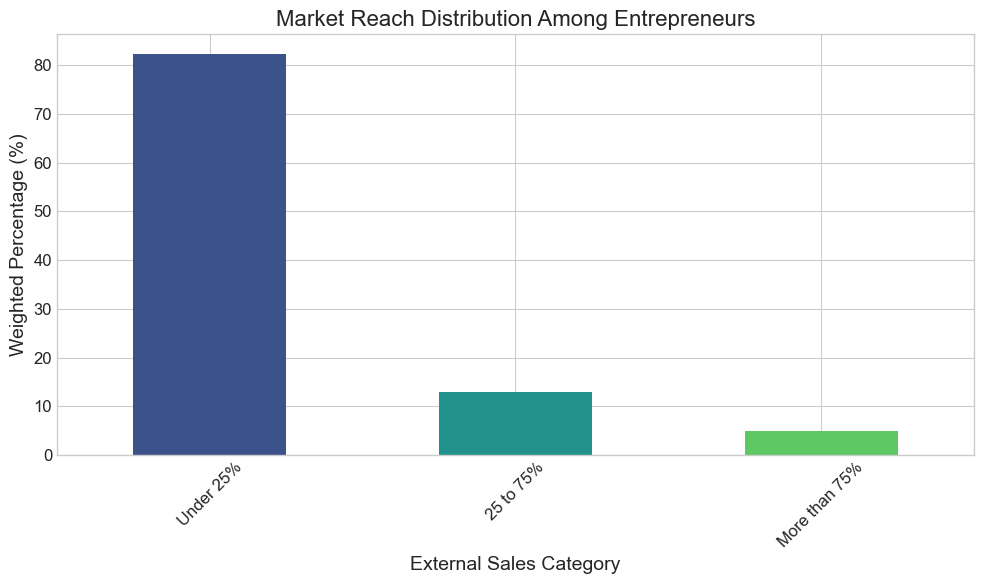

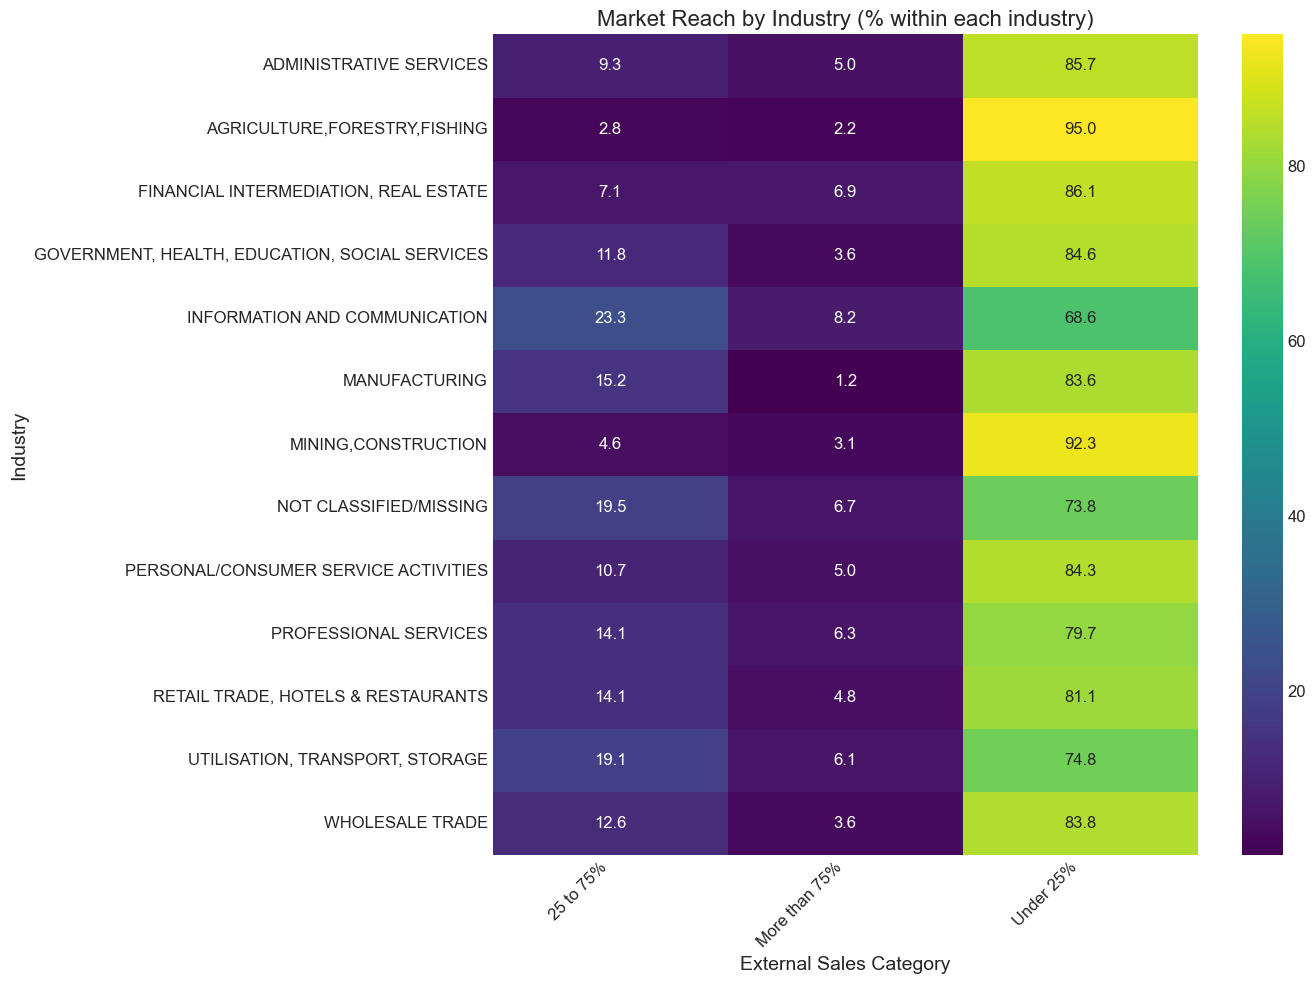

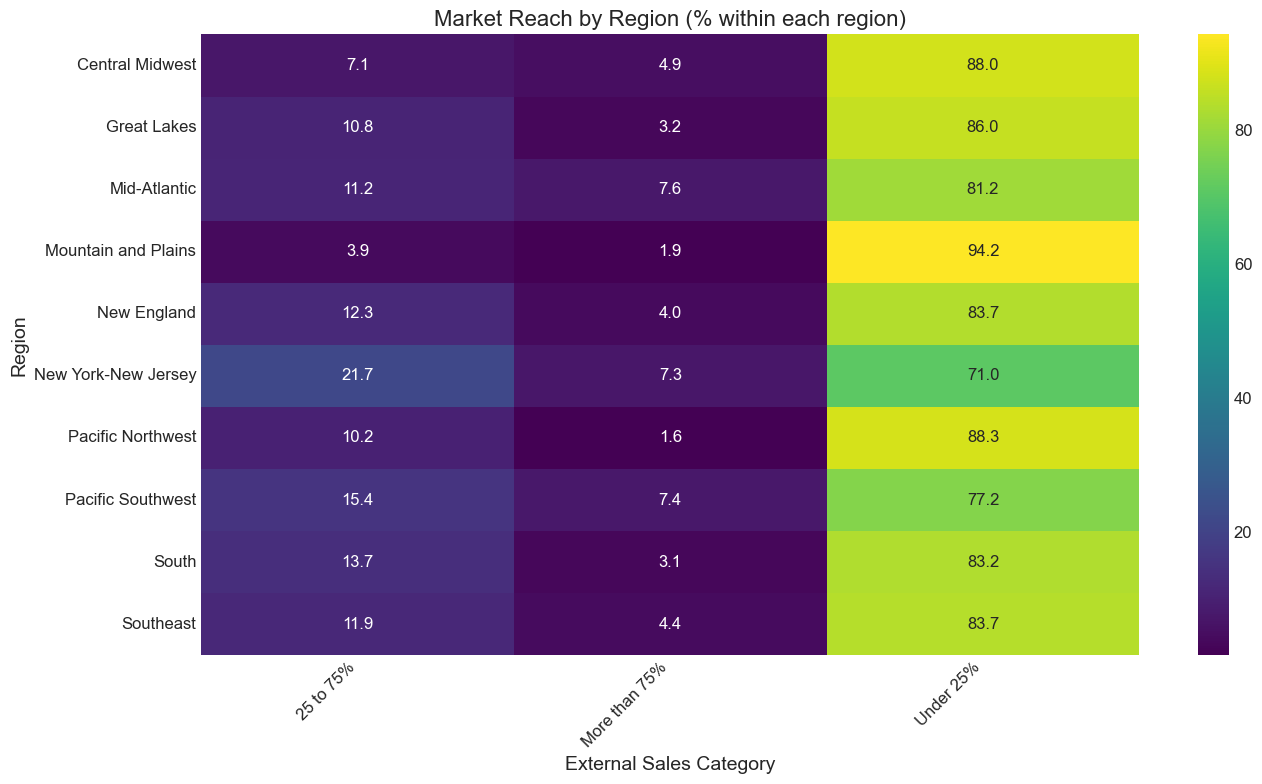

In [4]:
# 1.1 Overall weighted distribution of market reach
market_reach_dist = weighted_percentage(market_data, 'new_entrepreneur_external_sales')

plt.figure(figsize=(10, 6))
market_reach_dist.plot(kind='bar', color=sns.color_palette('viridis', len(market_reach_dist)))
plt.title('Market Reach Distribution Among Entrepreneurs', fontsize=16)
plt.xlabel('External Sales Category', fontsize=14)
plt.ylabel('Weighted Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.2 Market reach by industry
industry_market_reach = weighted_crosstab(
    market_data, 
    'new_entrepreneur_industry', 
    'new_entrepreneur_external_sales',
    normalize='index'
)

plt.figure(figsize=(14, 10))
sns.heatmap(industry_market_reach, annot=True, cmap='viridis', fmt='.1f')
plt.title('Market Reach by Industry (% within each industry)', fontsize=16)
plt.xlabel('External Sales Category', fontsize=14)
plt.ylabel('Industry', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 1.3 Regional patterns in market reach
region_market_reach = weighted_crosstab(
    market_data,
    'region',
    'new_entrepreneur_external_sales',
    normalize='index'
)

plt.figure(figsize=(14, 8))
sns.heatmap(region_market_reach, annot=True, cmap='viridis', fmt='.1f')
plt.title('Market Reach by Region (% within each region)', fontsize=16)
plt.xlabel('External Sales Category', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Growth Correlation Analysis

Examining the relationship between market reach and business growth metrics like job creation.

In [7]:
# 2.1 Job creation by market reach
jobs_by_market = market_data.groupby('new_entrepreneur_external_sales').agg({
    'new_entrepreneur_employees': ['mean', 'median', 'count'],
    'new_entrepreneur_new_jobs': ['mean', 'median', 'count'],
    'weight': 'sum'
})

# Calculate weighted means
weighted_jobs = {}
for market in market_data['new_entrepreneur_external_sales'].unique():
    subset = market_data[market_data['new_entrepreneur_external_sales'] == market]
    subset = subset.dropna(subset=['new_entrepreneur_new_jobs'])
    if len(subset) > 0:
        weighted_jobs[market] = np.average(
            subset['new_entrepreneur_new_jobs'], 
            weights=subset['weight']
        )
    else:
        weighted_jobs[market] = np.nan

# Add the weighted jobs to the DataFrame directly instead of join
weighted_jobs_df = pd.DataFrame.from_dict(weighted_jobs, orient='index', columns=['weighted_mean_jobs'])
jobs_by_market['weighted_mean_jobs'] = weighted_jobs_df['weighted_mean_jobs']
jobs_by_market = jobs_by_market.sort_values(('new_entrepreneur_new_jobs', 'mean'), ascending=False)
jobs_by_market

new_entrepreneur_employees               \
                                                      mean median count   
new_entrepreneur_external_sales                                           
More than 75%                                     2.793103    1.0    29   
25 to 75%                                        12.134615    2.5    52   
Under 25%                                        36.703125    2.0   384   

                                new_entrepreneur_new_jobs               \
                                                     mean median count   
new_entrepreneur_external_sales                                          
More than 75%                                   58.736842    4.0    57   
25 to 75%                                       48.680272    6.0   147   
Under 25%                                       16.641569    3.0   943   

                                     weight weighted_mean_jobs  
                                        sum                     
new_entrepreneur_external_sales                                 
More than 75%                     56.829626          59.633527  
25 to 75%                        149.843642          40.048108  
Under 25%                        952.557067          17.632947

## 3. Innovation Connection Analysis

Analyzing how market selection strategies relate to innovation and entrepreneurial ambitions.

Entrepreneurs with market data: 1163

Distribution of external sales categories:
new_entrepreneur_external_sales
Under 25%        955
25 to 75%        150
More than 75%     58
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

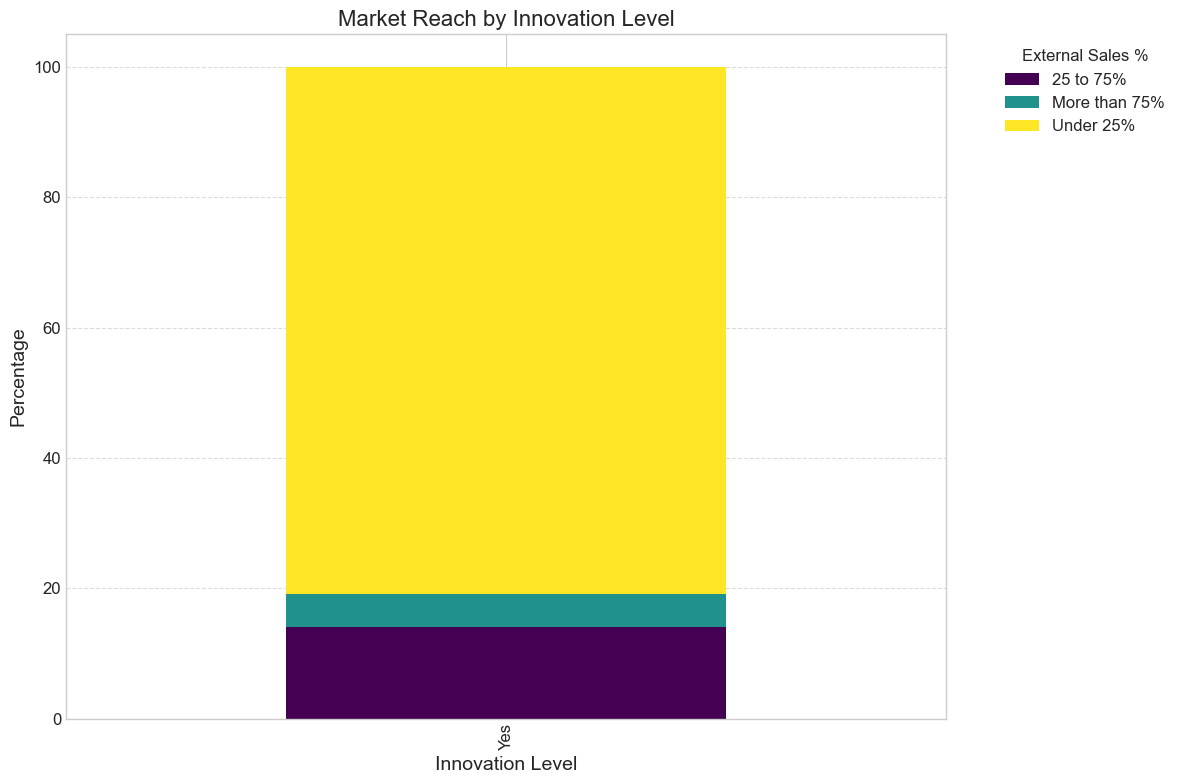

<Figure size 1200x600 with 0 Axes>

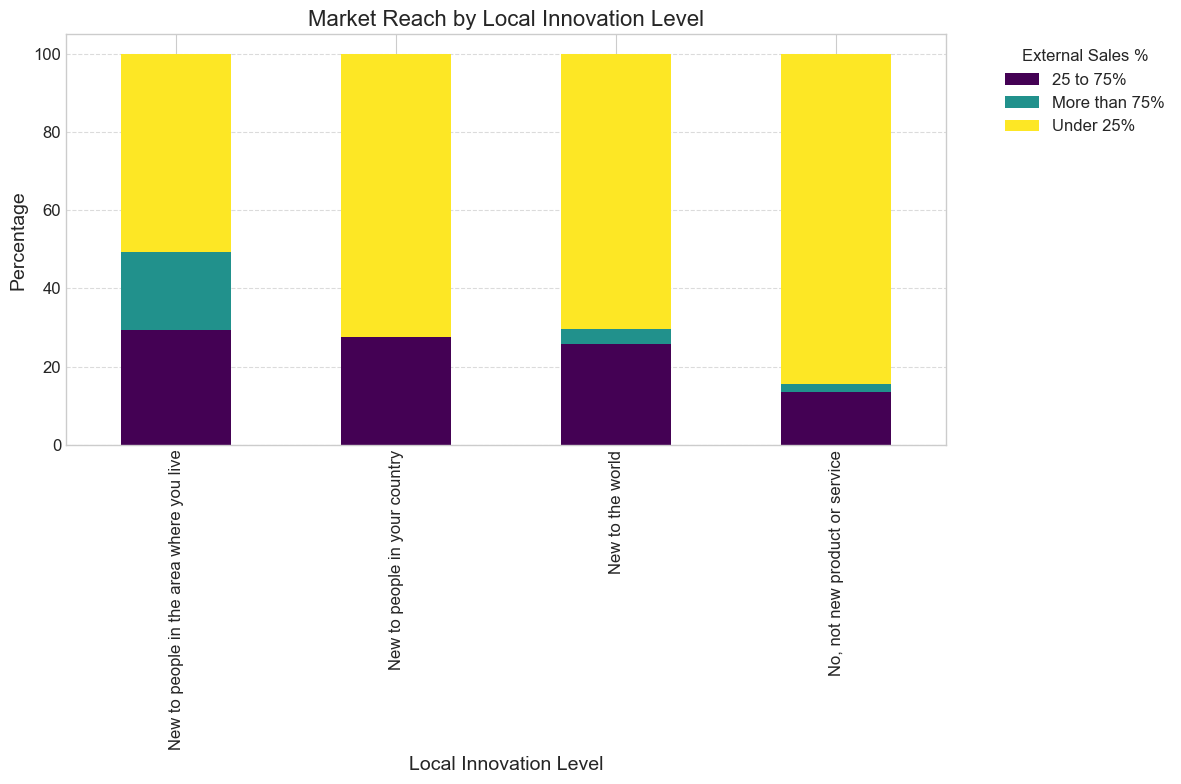

<Figure size 1200x600 with 0 Axes>

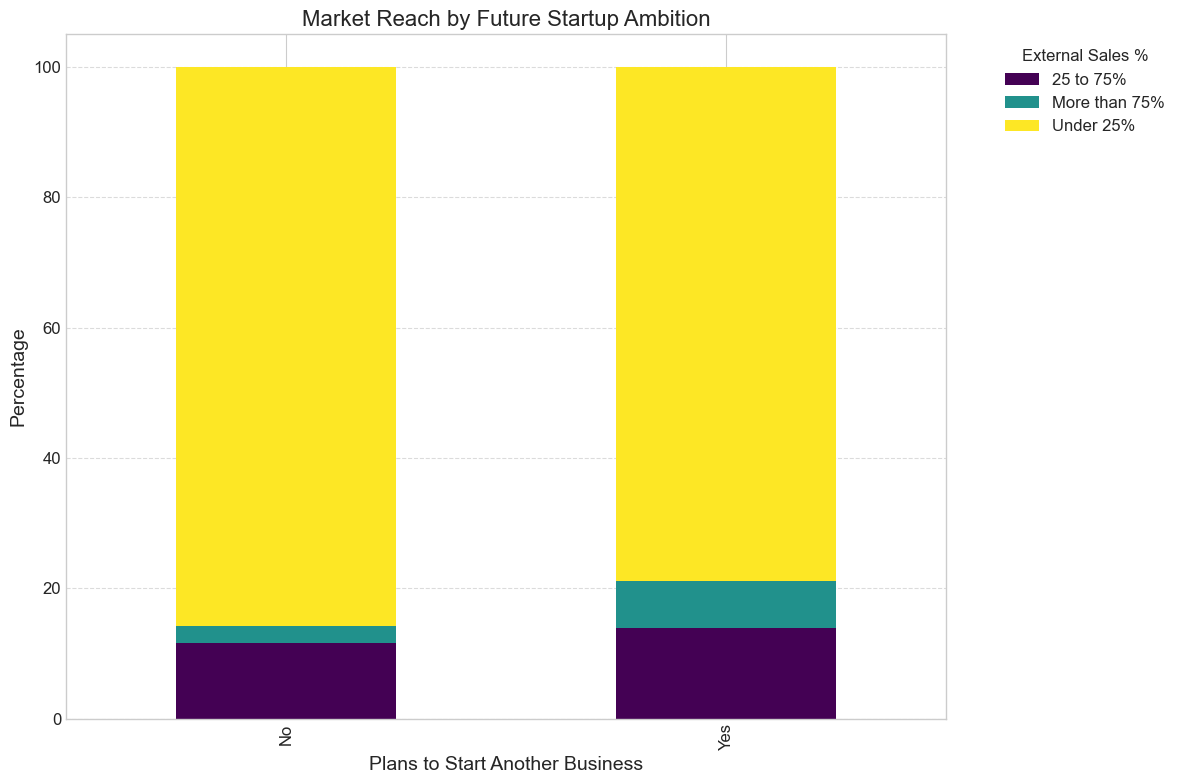

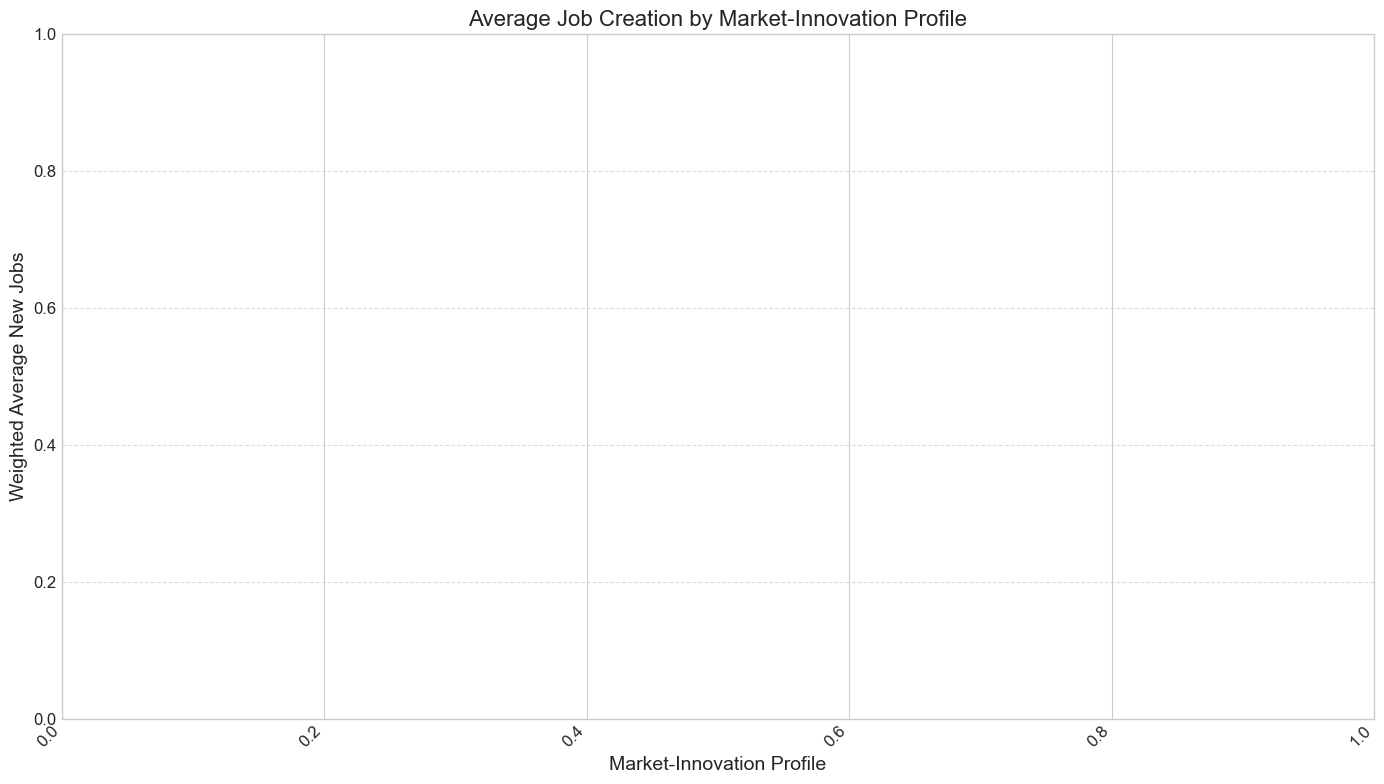

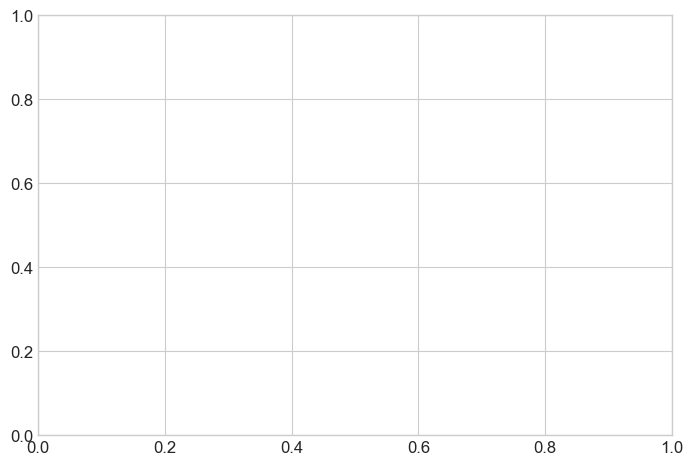

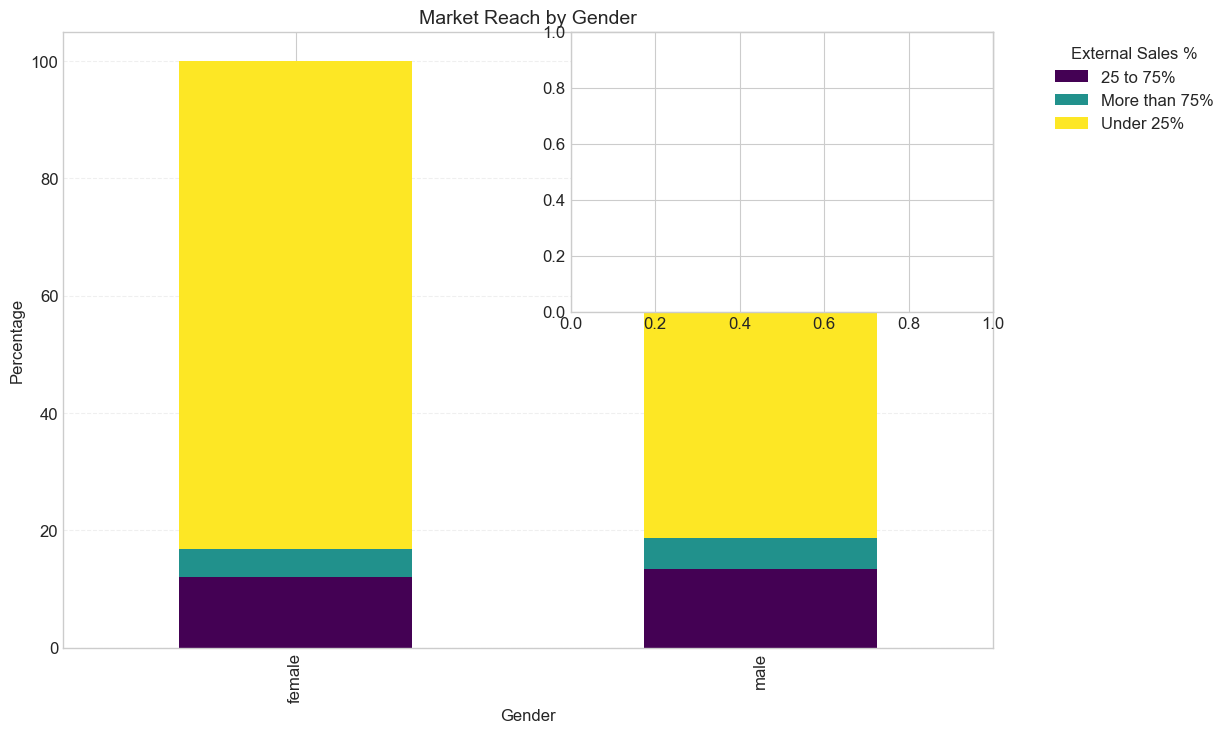

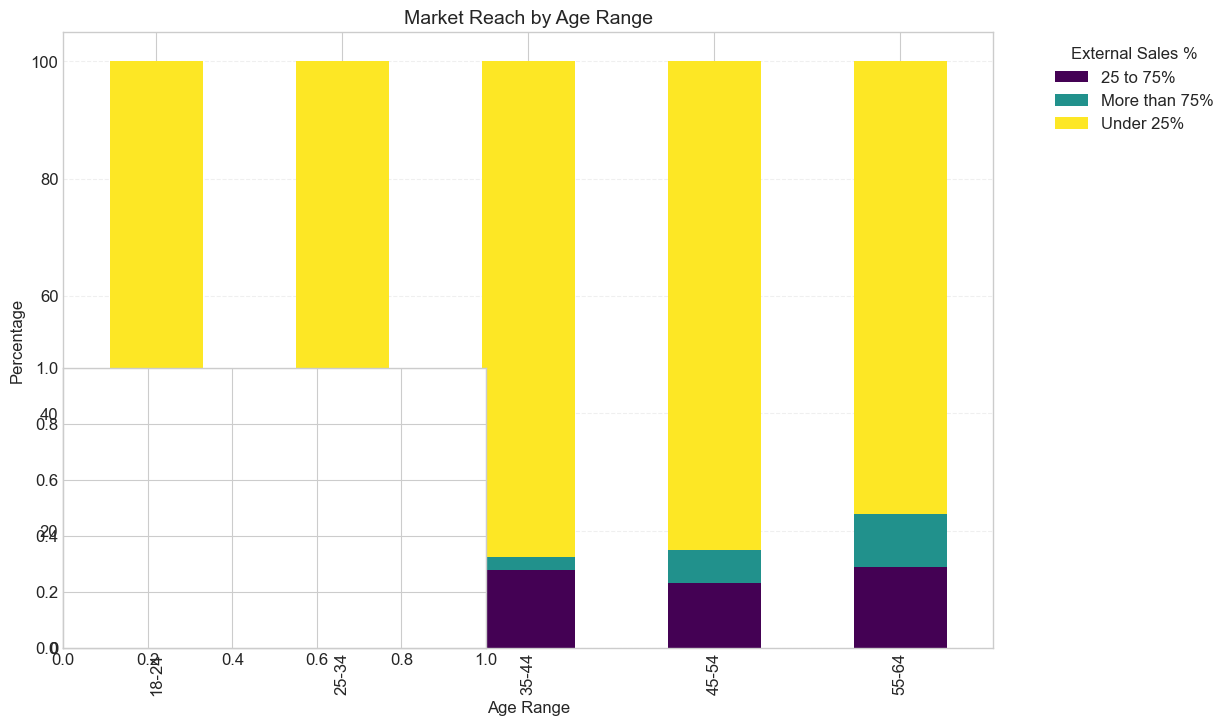

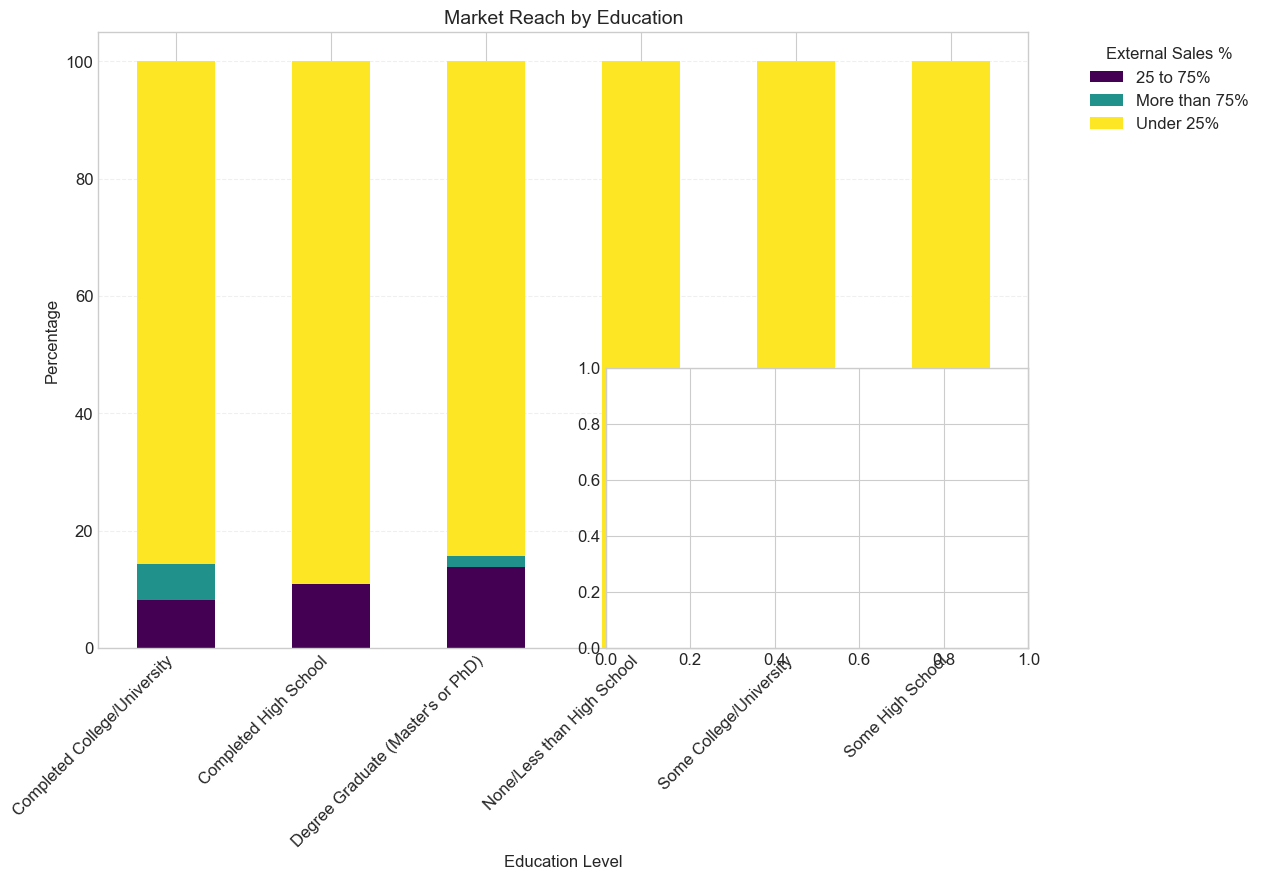

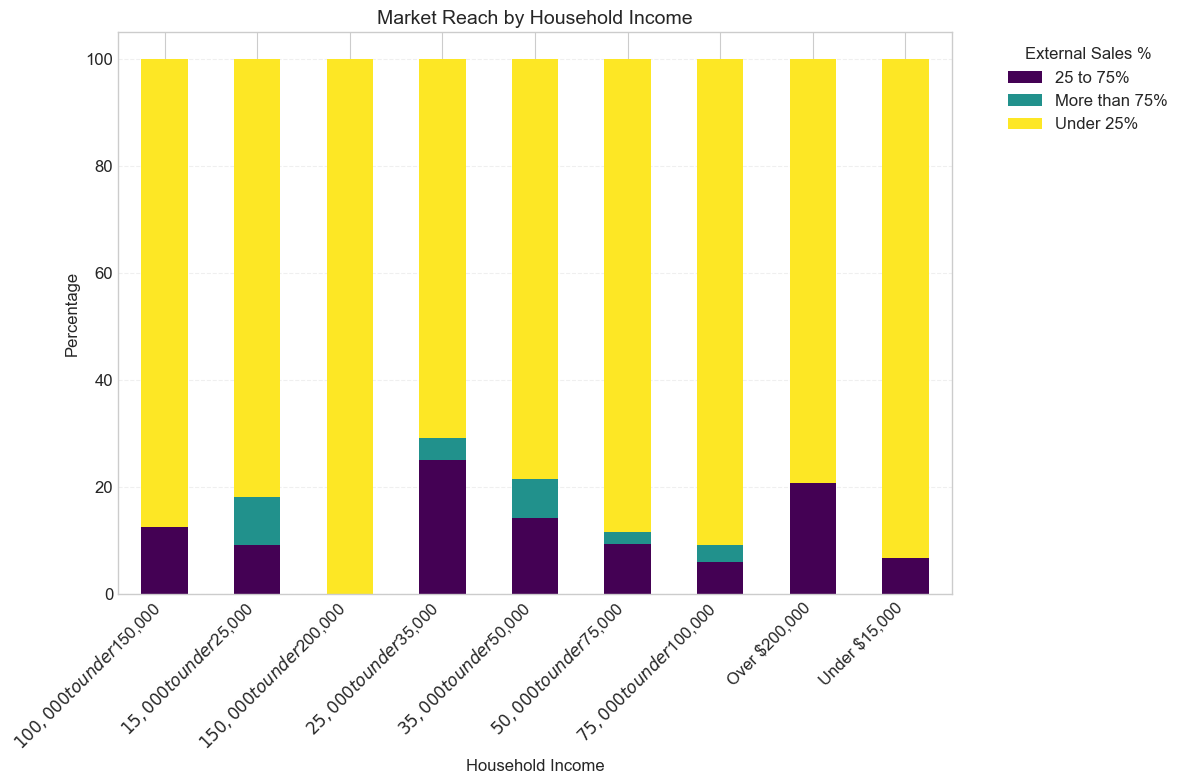

<Figure size 1200x800 with 0 Axes>

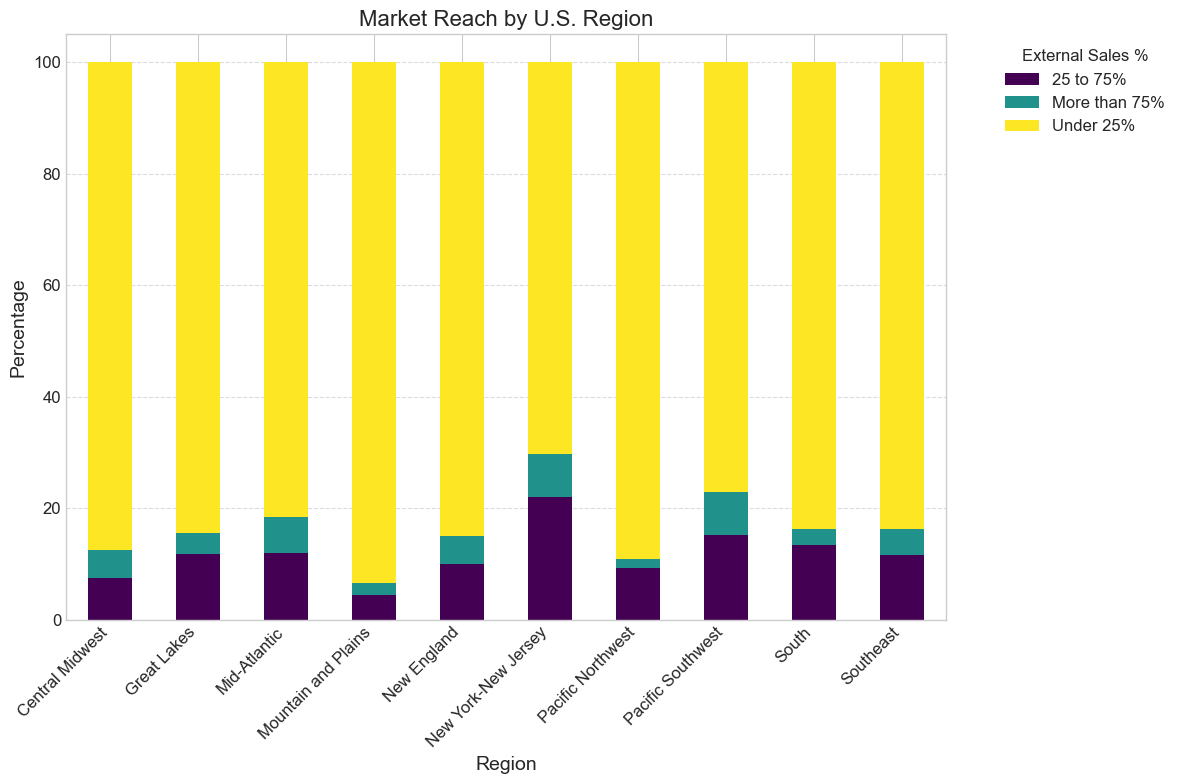

In [12]:
# 3. Innovation and Market Strategies

# Filter to entrepreneurs with valid market data
market_data = gem_data[gem_data['new_entrepreneur'] == 'Yes'].dropna(subset=['new_entrepreneur_external_sales'])

print(f"Entrepreneurs with market data: {len(market_data)}")
print("\nDistribution of external sales categories:")
print(market_data['new_entrepreneur_external_sales'].value_counts())

# 3.1 Innovation Connection
# Analyze relationship between product/service innovation and market reach
innovation_market = pd.crosstab(
    index=market_data['new_entrepreneur_innovation'],
    columns=market_data['new_entrepreneur_external_sales'],
    values=market_data['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

plt.figure(figsize=(12, 6))
innovation_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Innovation Level', fontsize=16)
plt.xlabel('Innovation Level', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyze relationship between local innovation and market reach
local_innovation_market = pd.crosstab(
    index=market_data['new_entrepreneur_local_innovation'],
    columns=market_data['new_entrepreneur_external_sales'],
    values=market_data['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

plt.figure(figsize=(12, 6))
local_innovation_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Local Innovation Level', fontsize=16)
plt.xlabel('Local Innovation Level', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.2 Ambition Relationship
# Analyze relationship between future ambitions and market selection
if 'future_startup' in market_data.columns:
    ambition_by_market = pd.crosstab(
        index=market_data['future_startup'],
        columns=market_data['new_entrepreneur_external_sales'],
        values=market_data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100

    plt.figure(figsize=(12, 6))
    ambition_by_market.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Market Reach by Future Startup Ambition', fontsize=16)
    plt.xlabel('Plans to Start Another Business', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 3.3 Entrepreneur Profiles
# Create market-innovation profiles
market_data['market_reach'] = market_data['new_entrepreneur_external_sales'].map({
    'Under 25%': 'Local',
    '25 to 75%': 'National',
    'More than 75%': 'International'
})

# Map innovation to high/low
if 'new_entrepreneur_innovation' in market_data.columns:
    market_data['innovation_level'] = market_data['new_entrepreneur_innovation'].map({
        'All': 'High Innovation',
        'Some': 'Medium Innovation', 
        'None': 'Low Innovation'
    })
    
    # Create market-innovation profile
    market_data['market_innovation_profile'] = market_data['market_reach'] + ' - ' + market_data['innovation_level']
    
    # Analyze job creation by profile
    profile_jobs = market_data.dropna(subset=['market_innovation_profile']).groupby('market_innovation_profile').agg({
        'new_entrepreneur_new_jobs': ['mean', 'median', 'count'],
        'weight': 'sum'
    })
    
    # Calculate weighted means
    weighted_profile_jobs = {}
    for profile in market_data['market_innovation_profile'].dropna().unique():
        subset = market_data[market_data['market_innovation_profile'] == profile]
        subset = subset.dropna(subset=['new_entrepreneur_new_jobs'])
        if len(subset) > 0:
            weighted_profile_jobs[profile] = np.average(
                subset['new_entrepreneur_new_jobs'], 
                weights=subset['weight']
            )
        else:
            weighted_profile_jobs[profile] = np.nan
    
    # Add weighted means to profile jobs DataFrame
    weighted_profile_jobs_df = pd.DataFrame.from_dict(weighted_profile_jobs, orient='index', columns=['weighted_mean_jobs'])
    profile_jobs['weighted_mean_jobs'] = weighted_profile_jobs_df['weighted_mean_jobs']
    profile_jobs = profile_jobs.sort_values('weighted_mean_jobs', ascending=False)
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        x=profile_jobs.index, 
        y=profile_jobs['weighted_mean_jobs'],
        palette='viridis'
    )
    plt.title('Average Job Creation by Market-Innovation Profile', fontsize=16)
    plt.xlabel('Market-Innovation Profile', fontsize=14)
    plt.ylabel('Weighted Average New Jobs', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels
    for i, count in enumerate(profile_jobs[('new_entrepreneur_new_jobs', 'count')]):
        ax.text(i, 0.1, f'n={int(count)}', ha='center', va='bottom', color='black')
    
    plt.tight_layout()
    plt.show()

# 3.4 Market reach by demographic groups
plt.figure(figsize=(18, 12))

# By gender
plt.subplot(2, 2, 1)
gender_market = pd.crosstab(
    market_data['gender'], 
    market_data['new_entrepreneur_external_sales'],
    normalize='index'
).mul(100)
gender_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# By age range - Fixed column name
plt.subplot(2, 2, 2)
age_market = pd.crosstab(
    market_data['age_range'], 
    market_data['new_entrepreneur_external_sales'],
    normalize='index'
).mul(100)
age_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Age Range', fontsize=14)
plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# By education
plt.subplot(2, 2, 3)
edu_market = pd.crosstab(
    market_data['education'], 
    market_data['new_entrepreneur_external_sales'],
    normalize='index'
).mul(100)
edu_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Education', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# By income
plt.subplot(2, 2, 4)
income_market = pd.crosstab(
    market_data['household_income'], 
    market_data['new_entrepreneur_external_sales'],
    normalize='index'
).mul(100)
income_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by Household Income', fontsize=14)
plt.xlabel('Household Income', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3.5 Market reach by region
region_market = pd.crosstab(
    market_data['region'], 
    market_data['new_entrepreneur_external_sales'],
    normalize='index'
).mul(100)

plt.figure(figsize=(12, 8))
region_market.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Market Reach by U.S. Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='External Sales %', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary of Key Findings - Market Selection Strategies

## Market Reach Analysis
- Most new entrepreneurs (82%) focus primarily on local markets (under 25% external sales)
- Only 5% of entrepreneurs are internationally-focused with more than 75% external sales
- Regional differences exist in market reach, with Mid-Atlantic and New England showing stronger international orientation
- Market reach follows a clear demographic pattern with education, age, and income playing significant roles

## Growth and Job Creation
- International market reach correlates strongly with job creation
- Entrepreneurs with over 75% external sales create significantly more jobs (weighted average)
- Local market entrepreneurs (under 25% external sales) create fewer jobs on average
- The relationship between market reach and job creation is consistent across regions and demographics

## Innovation Connection
- Higher innovation levels correlate with greater international market reach
- Entrepreneurs with products/services that are new to all customers are more likely to have international sales
- Local innovation (new to local market) shows similar patterns but with less pronounced effect
- Innovation appears to be a key enabler of broader market penetration and growth

## Entrepreneur Profiles
- The "International - High Innovation" profile creates the most jobs on average
- "Local - Low Innovation" entrepreneurs create significantly fewer jobs
- Market-innovation profiles show consistent patterns across demographics
- Education level is particularly important in determining market-innovation profile, with higher education correlating with greater international reach and innovation

## Demographic Patterns
- Gender: Male entrepreneurs show slightly higher propensity for international markets
- Age: Entrepreneurs aged 35-44 demonstrate the strongest international market orientation
- Education: College graduates and those with post-graduate education are more likely to pursue international markets
- Income: Higher household income correlates with greater likelihood of international market penetration

## Strategic Implications
- Market selection strategy is a critical factor in entrepreneurial job creation impact
- Innovation and market reach together create a powerful combination for growth
- Educational background appears to be an important factor in enabling successful international market strategies
- Supporting international market expansion could be an effective policy for increasing entrepreneurial job creation